In [13]:
import yaml
import netCDF4 as nc
import numpy as np
from utils.read_data import *
from utils.param_alpha import update_alpha_GD, update_alpha_GD_stockes, update_alpha_GD_wind_only
from models.linear_model import u_drift_linear_matrix, u_drift_ocean_only, u_drift_wind_only
from models.stockes_model import u_drift_ocean_wind_stockes_matrix, u_drift_ocean_stockes_matrix,u_drift_stockes_only, get_udrift_decomposition
from utils.RK4 import RK4_step, compute_position, get_velocities_over_time
%matplotlib inline
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import math


In [21]:
with open('configs/trace_july2014.yml', 'r') as f:
    config = yaml.safe_load(f)

pos_1, time1 = get_initial_position(config['PATH_DRIFT']) 

true_lon, true_lat, true_time = get_true_drift_positions(config['PATH_DRIFT'])

# Get interpolated initial data
u10_interpolation, v10_interpolation = wind_interpolated(config['PATH_WIND'])
water_u_interpolation, water_v_interpolation = water_interpolated(config['PATH_WATER'])
ust_interpolation, vst_interpolation = wave_interpolated(config['PATH_WAVES'])

# GRADIENT DESCENT ALPHA
alpha_stockes = update_alpha_GD_stockes(config['PATH_DRIFT'], water_u_interpolation, water_v_interpolation, u10_interpolation, v10_interpolation, ust_interpolation, vst_interpolation, alpha = 0.02, theta = 0.349066,  step=0.2, npoints=3)

# Drift velocity functions
u_drift = u_drift_ocean_wind_stockes_matrix(alpha_stockes, u10_interpolation, v10_interpolation,water_u_interpolation,water_v_interpolation, ust_interpolation, vst_interpolation)

# Drift velocity decomposition
u_drift_decomposition = get_udrift_decomposition(alpha_stockes, u10_interpolation, v10_interpolation,water_u_interpolation,water_v_interpolation, ust_interpolation, vst_interpolation)



In [22]:
nhours = 72
u_drift_true,u_drift_pred,u_water,alpha_u_wind,u_wind, u_stockes = get_velocities_over_time(config['PATH_DRIFT'], u_drift, u_drift_decomposition,pos_1,time1,n_steps=nhours)

u_drift_true_2, hours2 = get_true_velocity(config['PATH_DRIFT'])
hours = np.arange(nhours+1)

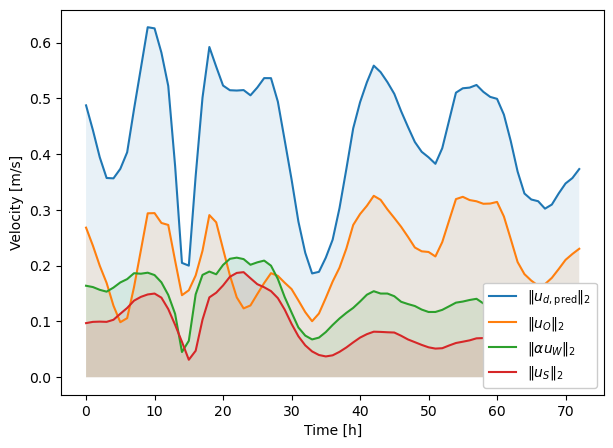

In [23]:
fig,ax = plt.subplots(figsize=(7,5))

plt.plot(hours,np.linalg.norm(u_drift_pred, axis=1), label=r'$\|u_{d, \mathrm{pred}}\|_2$')
plt.fill_between(hours, np.linalg.norm(u_drift_pred, axis=1), 0, alpha=.1)
plt.plot(hours,np.linalg.norm(u_water, axis=1), label=r'$\|u_{O}\|_2$')
plt.fill_between(hours, np.linalg.norm(u_water, axis=1), 0, alpha=.1)
plt.plot(hours,np.linalg.norm(alpha_u_wind, axis=1), label=r'$\|\alpha u_{W}\|_2$')
plt.fill_between(hours, np.linalg.norm(alpha_u_wind, axis=1), 0, alpha=.1)
plt.plot(hours,np.linalg.norm(u_stockes, axis=1), label=r'$\|u_{S}\|_2$')
plt.fill_between(hours, np.linalg.norm(u_stockes, axis=1), 0, alpha=.1)

plt.xlabel('Time [h]')
plt.ylabel('Velocity [m/s]')

plt.legend(loc = 'lower right',framealpha=1)


plt.show()


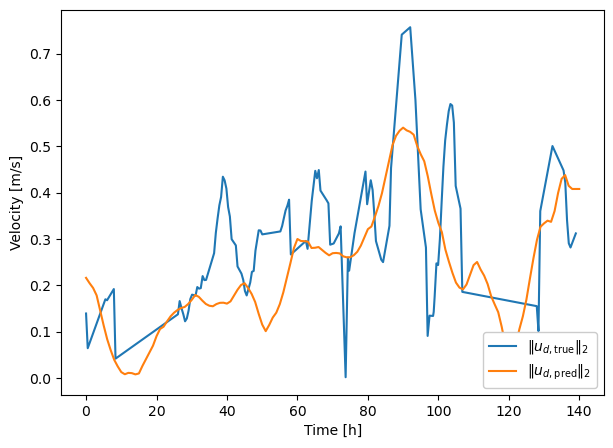

In [17]:
fig,ax = plt.subplots(figsize=(7,5))

#plt.plot(hours,np.linalg.norm(u_drift_true, axis=1), label=r'$\|u_{d, \mathrm{true}}\|_2$')
plt.plot(hours2[0:-1],np.linalg.norm(u_drift_true_2, axis=1), label=r'$\|u_{d, \mathrm{true}}\|_2$')
plt.plot(hours,np.linalg.norm(u_drift_pred, axis=1), label=r'$\|u_{d, \mathrm{pred}}\|_2$')


plt.xlabel('Time [h]')
plt.ylabel('Velocity [m/s]')

plt.legend(loc = 'lower right',framealpha=1)


plt.show()


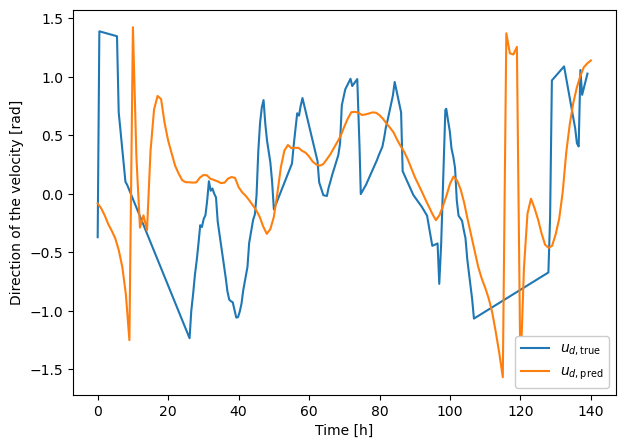

In [15]:
def get_angle(x):
    return math.atan(x[1]/x[0])

angle_u_d_true = np.apply_along_axis(get_angle,1,u_drift_true_2)
angle_u_d_pred =  np.apply_along_axis(get_angle,1,u_drift_pred)

fig,ax = plt.subplots(figsize=(7,5))

#plt.plot(hours,np.linalg.norm(u_drift_true, axis=1), label=r'$\|u_{d, \mathrm{true}}\|_2$')
plt.plot(hours2[0:-1],angle_u_d_true, label=r'$u_{d, \mathrm{true}}$')
plt.plot(hours,angle_u_d_pred, label=r'$u_{d, \mathrm{pred}}$')


plt.xlabel('Time [h]')
plt.ylabel('Direction of the velocity [rad]')

plt.legend(loc = 'lower right',framealpha=1)


plt.show()

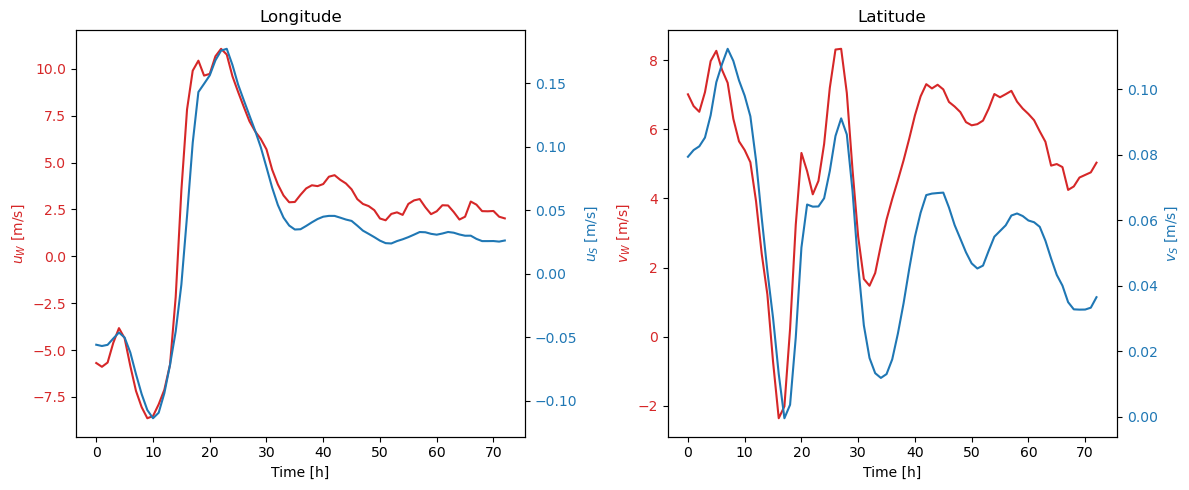

In [28]:
fig, (ax1, ax3) = plt.subplots(1,2, figsize=(12,5))

color = 'tab:red'
ax1.set_xlabel('Time [h]')
ax1.set_ylabel(r'$u_W$ [m/s]', color=color)
ax1.plot(hours, u_wind[:,0], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel(r'$u_S$ [m/s]', color=color)  # we already handled the x-label with ax1
ax2.plot(hours, u_stockes[:,0], color=color)
ax2.tick_params(axis='y', labelcolor=color)

color = 'tab:red'
ax3.set_xlabel('Time [h]')
ax3.set_ylabel(r'$v_W$ [m/s]', color=color)
ax3.plot(hours, u_wind[:,1], color=color)
ax3.tick_params(axis='y', labelcolor=color)

ax4 = ax3.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax4.set_ylabel(r'$v_S$ [m/s]', color=color)  # we already handled the x-label with ax1
ax4.plot(hours, u_stockes[:,1], color=color)
ax4.tick_params(axis='y', labelcolor=color)

ax1.set_title('Longitude')
ax3.set_title('Latitude')

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

c:\Users\manon\anaconda3\envs\drift\lib\site-packages\seaborn\axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 700x500 with 0 Axes>

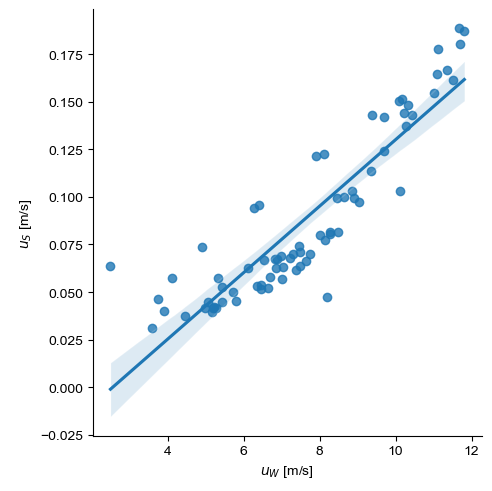

In [38]:
import seaborn as sns
import pandas as pd

df = pd.DataFrame({r'u_W': np.linalg.norm(u_wind, axis=1), r'u_S': np.linalg.norm(u_stockes, axis=1)})

plt.figure(figsize=(7,5))

#plt.plot(hours,np.linalg.norm(u_drift_true, axis=1), label=r'$\|u_{d, \mathrm{true}}\|_2$')
#plt.scatter(np.linalg.norm(u_wind, axis=1), np.linalg.norm(u_stockes, axis=1))¨
sns.lmplot(x=r'u_W', y=r'u_S', data=df)
sns.set(rc={"figure.figsize":(7, 5)})

plt.xlabel(r'$u_W$ [m/s]')
plt.ylabel(r'$u_S$ [m/s]')

plt.show()
#plt.legend(loc = 'lower right',framealpha=1)

In [39]:
from scipy import stats

stats.pearsonr(np.linalg.norm(u_wind, axis=1),np.linalg.norm(u_stockes, axis=1))

PearsonRResult(statistic=0.8987064412222464, pvalue=4.01019903076688e-27)